# Project - Part IV: Dynamic Hedging:

Suppose $$S_0 = 100, \, \sigma = 0.2, \, r = 5\%, \, T = \frac{1}{12} \, \text{year (1 month)}, \, \text{and} \, K = 100.$$

Use a Black-Scholes model to simulate the stock price. Suppose we
sell this at-the-money call option, and we hedge N times during the life of the
call option. Assume there are 21 trading days over the month.

Work out the hedging error of the dynamic delta hedging strategy by
comparing the replicated position based on ϕ and ψ with the final call option
payoff at maturity.
Use 50,000 paths in your simulation, and plot the histogram of the hedging
error for N = 21 and N = 84.

The dynamic hedging strategy for the call option is $C_t=\phi_tS_t-\psi_tB_t$, where 
\begin{equation*}
\phi_t=\Delta_t=\frac{\partial C}{\partial S}=\Phi\left(\frac{\log\frac{St}{K}+\left(r+\frac{\sigma^2}{2}\right)(T-t)}{\sigma\sqrt{T-t}}\right)
\end{equation*}

and

\begin{equation*}
\psi_tB_t=-Ke^{-r(T-t)}\Phi\left(\frac{\log\frac{St}{K}+\left(r-\frac{\sigma^2}{2}\right)(T-t)}{\sigma\sqrt{T-t}}\right)
\end{equation*}

In [3]:
from scipy.stats import norm
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
from matplotlib.ticker import PercentFormatter

#### 1. Parameters Setting

In [5]:
paths = 50000
maturity = 1/12 #1month

r = 0.05
S0 = 100.0 
K = 100.0 #strike price
sigma = 0.2 #volatility

#### 2. Define Delta, Bond, Brownian Motion and Hedging Error Function

In [7]:
#Delta
def phi(S, K, r, sigma, T):
    d1 = (np.log(S/K)+(r+sigma**2/2)*T) / (sigma*np.sqrt(T))
    return norm.cdf(d1)

#Bond
def psi_Bt(S, K, r, sigma, T):
    d1 = (np.log(S/K)+(r+sigma**2/2)*T) / (sigma*np.sqrt(T))
    d2 = d1 - sigma*np.sqrt(T)
    return -K*np.exp(-r*T)*norm.cdf(d2)

#Brownian Motion
def simulate_Brownian_Motion(paths, steps, T):
    deltaT = T/steps
    t = np.linspace(0, T, steps+1)
    X = np.c_[np.zeros((paths, 1)),
              np.random.randn(paths, steps)]
    return t, np.cumsum(np.sqrt(deltaT) * X, axis=1)


#Hedging error calculation
def hedge_error(blackscholespath, T, maturity, S0, K, r, sigma, dt):
    stockhedge_errors = []
    bondhedge_errors = []
    prev_phi, prev_bond_pos = 0, 0  

    for t, S_t in zip(T, blackscholespath):
        stock_pos = phi(S_t, K, r, sigma, maturity - t) * S_t
        bond_pos = psi_Bt(S_t, K, r, sigma, maturity - t)
        if t == 0.0:
            stockhedge_errors.append(0)
            bondhedge_errors.append(0)
        else:
            stockhedge_errors.append(prev_phi * S_t - stock_pos)
            bondhedge_errors.append(prev_bond_pos * np.exp(r * dt) - bond_pos)

        prev_phi = phi(S_t, K, r, sigma, maturity - t)
        prev_bond_pos = bond_pos

    return sum(stockhedge_errors) + sum(bondhedge_errors)

#### 3. Black-Scholes Model Stock Price Simulation (50000 Path, N=21 & 84 under Brownian Motion)

In [9]:
hedging_error_21 = []
steps = 21
dt = maturity / steps

for i in range(paths):  
    T, W_T = simulate_Brownian_Motion(1, steps, maturity)  
    blackscholespath = S0 * np.exp((r - sigma**2 / 2) * T + sigma * W_T[0])
    hedge_error_21 = hedge_error(blackscholespath, T, maturity, S0, K, r, sigma, dt)
    hedging_error_21.append(hedge_error_21)

hedging_error_84 = []
steps = 84
dt = maturity / steps
for i in range(paths):
    T, W_T = simulate_Brownian_Motion(1, steps, maturity)
    blackscholespath = S0*np.exp((r-sigma**2/2)*T + sigma*W_T[0])
    hedge_error_84 = hedge_error(blackscholespath, T, maturity, S0, K, r, sigma, dt)
    hedging_error_84.append(hedge_error_84)


/var/folders/4_/13c00ksn1jx454xlgpw4h_vc0000gn/T/ipykernel_34014/277283976.py:3: RuntimeWarning: divide by zero encountered in scalar divide
  d1 = (np.log(S/K)+(r+sigma**2/2)*T) / (sigma*np.sqrt(T))
/var/folders/4_/13c00ksn1jx454xlgpw4h_vc0000gn/T/ipykernel_34014/277283976.py:8: RuntimeWarning: divide by zero encountered in scalar divide
  d1 = (np.log(S/K)+(r+sigma**2/2)*T) / (sigma*np.sqrt(T))


#### 4-1. Dynamic Hedging - Hedging Error Histogram (N=21 and N=84)

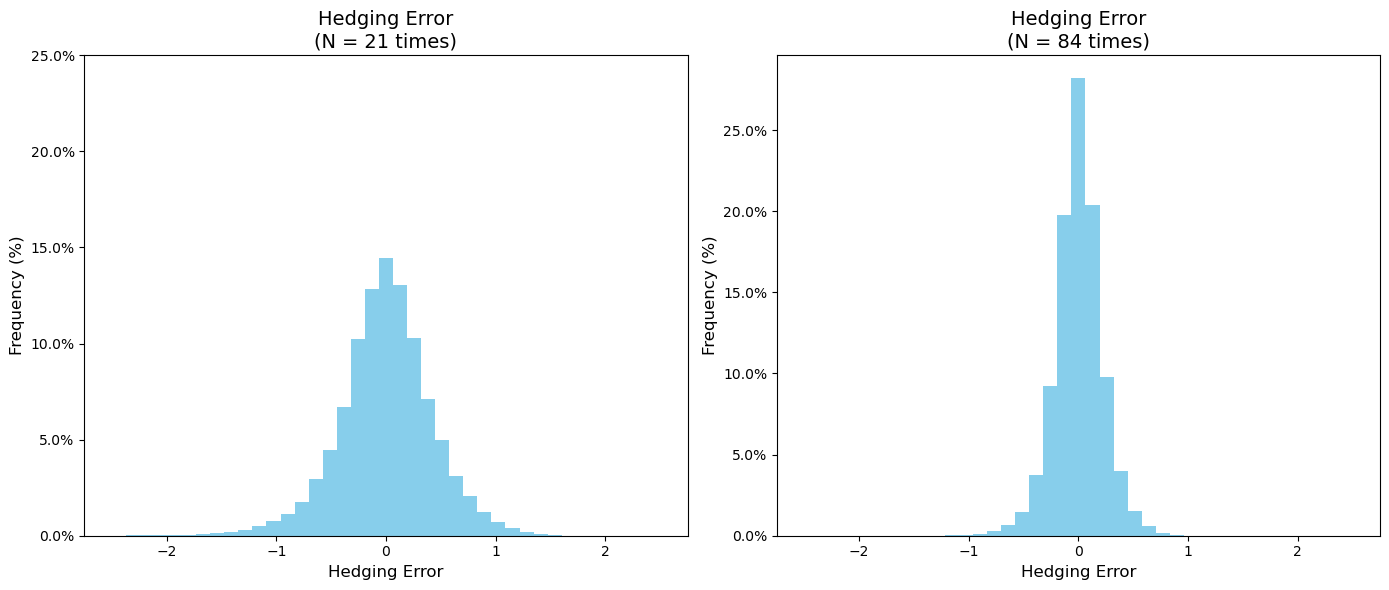

In [11]:
def hedging_error_histogram(hedging_error, N):
    plt.hist(hedging_error, weights=np.ones(len(hedging_error)) / len(hedging_error),
             bins=np.linspace(-2.5, 2.5, 40), color='skyblue') 
    plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
    plt.title(f'Hedging Error\n(N = {N} times)', fontsize=14)  
    plt.xlabel('Hedging Error', fontsize=12)
    plt.ylabel('Frequency (%)', fontsize=12)
    plt.yticks(np.arange(0, 0.3, 0.05)) 

plt.figure(figsize=(14, 6))  
plt.subplot(121)
hedging_error_histogram(hedging_error_21, 21)

plt.subplot(122)
hedging_error_histogram(hedging_error_84, 84)
plt.tight_layout()
plt.show()


#### 4-2. Dynamic Hedging - Mean and Standard deviation of Hedging Times

In [13]:
mean_21 = np.mean(hedging_error_21)
std_21 = np.std(hedging_error_21)
max_21 = np.max(hedging_error_21)
min_21 = np.min(hedging_error_21)

mean_84 = np.mean(hedging_error_84)
std_84 = np.std(hedging_error_84)
max_84 = np.max(hedging_error_84)
min_84 = np.min(hedging_error_84)


mean_std ={
    "Hedging Times": [21, 84],
    "Mean of Hedging Error": [mean_21, mean_84],
    "Std of Hedging Error": [std_21, std_84],
    "Min Hedging Error":[min_21, min_84],
    "Max Hedging Error":[max_21, max_84]

    }

mean_std = pd.DataFrame(mean_std).set_index("Hedging Times")
mean_std



,Mean of Hedging Error,Std of Hedging Error,Min Hedging Error,Max Hedging Error
Hedging Times,,,,
21,-0.002962,0.426702,-3.284642,1.688436
84,0.000690,0.217406,-1.650525,1.044974
